In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import os

In [2]:
dataset_dir = 'D:\Research\Ongoing Work\Paper 1\Code with K Fold\Dataset'

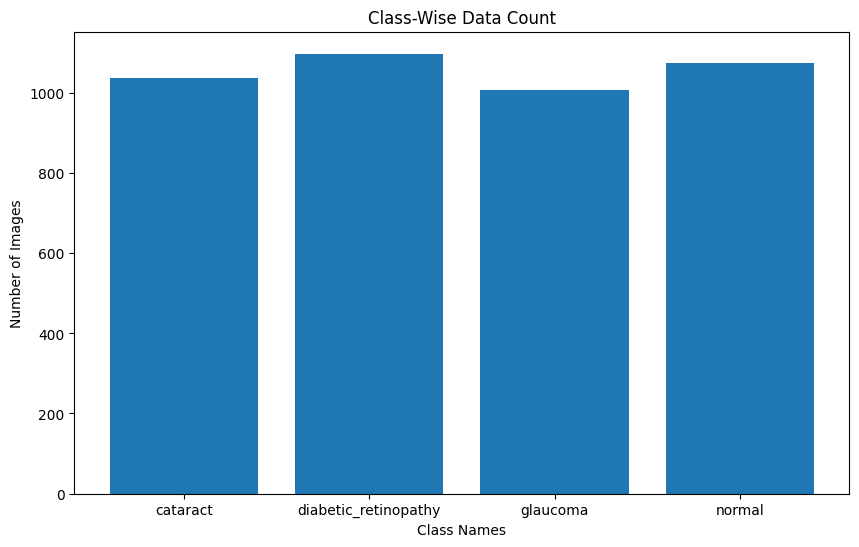

In [3]:
class_counts = {}
for subdir, dirs, files in os.walk(dataset_dir):
    for dir in dirs:
        class_counts[dir] = len(os.listdir(os.path.join(subdir, dir)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class-Wise Data Count')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.show()

In [4]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


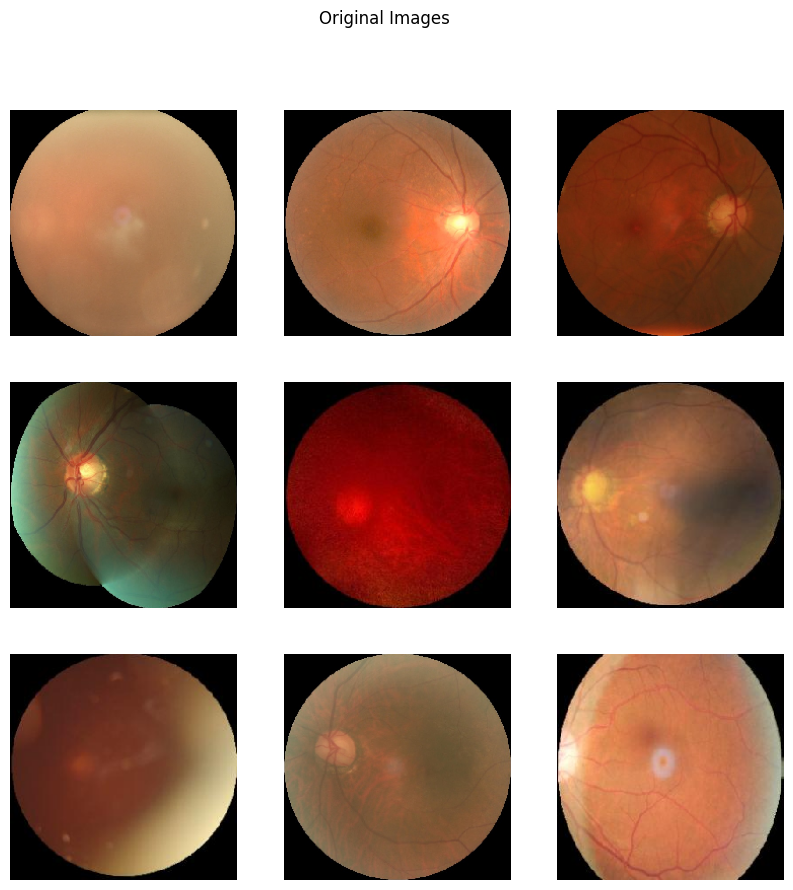

Found 4217 images belonging to 4 classes.


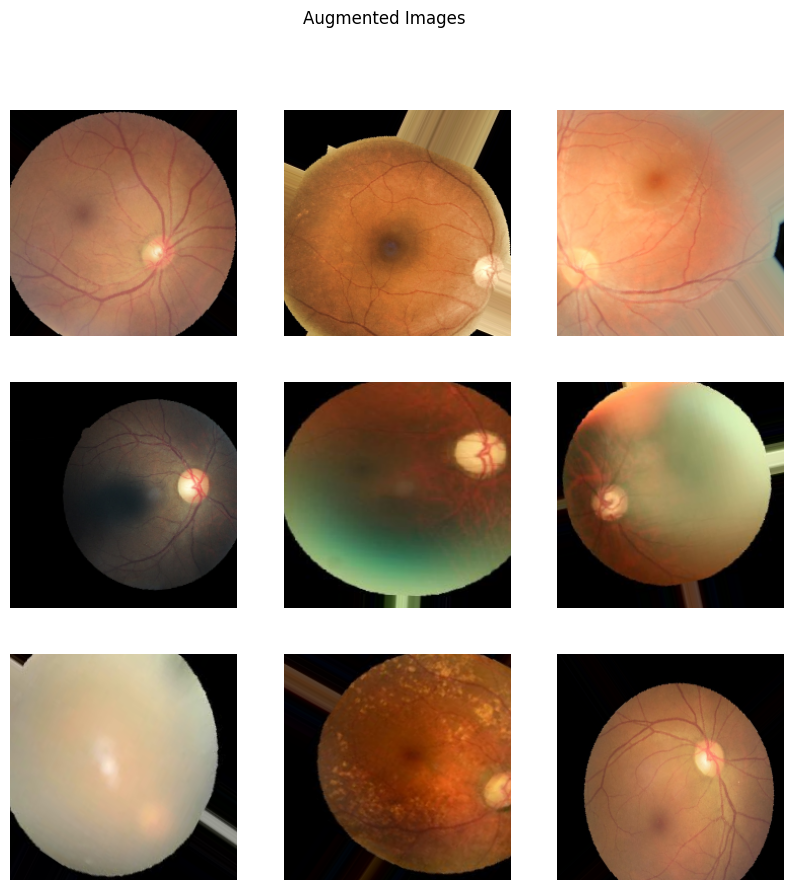

In [5]:
def plot_images(generator, title):
    sample_images, _ = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_generator, "Original Images")
plot_images(augmented_datagen.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=32, class_mode='sparse', subset='training'), "Augmented Images")

In [6]:
def create_hybrid_model(input_shape=(224, 224, 3), num_classes=len(class_counts)):
    input_tensor = Input(shape=input_shape)

    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in mobilenet_base.layers:
        layer.trainable = False
    mobilenet_features = Flatten()(mobilenet_base.output)
    mobilenet_features = Dense(256, activation='relu')(mobilenet_features)
    mobilenet_features = BatchNormalization()(mobilenet_features)
    mobilenet_features = Dropout(0.5)(mobilenet_features)

    vgg19_base = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in vgg19_base.layers:
        layer.trainable = False
    vgg19_features = Flatten()(vgg19_base.output)
    vgg19_features = Dense(256, activation='relu')(vgg19_features)
    vgg19_features = BatchNormalization()(vgg19_features)
    vgg19_features = Dropout(0.5)(vgg19_features)

    combined_features = Concatenate()([mobilenet_features, vgg19_features])
    x = Dense(512, activation='relu')(combined_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [7]:
def generator_to_numpy(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        img, lbl = next(generator)
        images.append(img)
        labels.append(lbl)
    return np.concatenate(images), np.concatenate(labels)

X, y = generator_to_numpy(train_generator)

In [8]:
def calculate_metrics(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    return TPR, TNR, FPR, FNR

Training fold 1...


C:\Users\User\AppData\Local\Temp\ipykernel_6396\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 914s 11s/step - accuracy: 0.5176 - loss: 1.4143 - val_accuracy: 0.7988 - val_loss: 0.4959
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3104s 37s/step - accuracy: 0.7664 - loss: 0.6675 - val_accuracy: 0.8935 - val_loss: 0.3079
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 762s 8s/step - accuracy: 0.8271 - loss: 0.5038 - val_accuracy: 0.9053 - val_loss: 0.2917
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 615s 7s/step - accuracy: 0.8728 - loss: 0.4024 - val_accuracy: 0.9127 - val_loss: 0.2793
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - accuracy: 0.8688 - loss: 0.3864 - val_accuracy: 0.9172 - val_loss: 0.2650
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - accuracy: 0.9017 - loss: 0.3065 - val_accuracy: 0.9186 - val_loss: 0.2713
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 728s 9s/step - accuracy: 0.8800 - loss: 0.3263 - val_accuracy: 0.9142 - val_loss: 0.3023
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - accuracy: 0.9134 - loss: 0.2660 - val_accuracy: 0.9186 

C:\Users\User\AppData\Local\Temp\ipykernel_6396\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 627s 7s/step - accuracy: 0.5422 - loss: 1.3216 - val_accuracy: 0.8889 - val_loss: 0.3540
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - accuracy: 0.7905 - loss: 0.5798 - val_accuracy: 0.9141 - val_loss: 0.2715
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.8444 - loss: 0.4619 - val_accuracy: 0.9156 - val_loss: 0.2551
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.8477 - loss: 0.4246 - val_accuracy: 0.9156 - val_loss: 0.2422
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - accuracy: 0.8777 - loss: 0.3551 - val_accuracy: 0.9304 - val_loss: 0.2005
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - accuracy: 0.8821 - loss: 0.3393 - val_accuracy: 0.9289 - val_loss: 0.2163
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.9061 - loss: 0.2741 - val_accuracy: 0.9304 - val_loss: 0.2260
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 618s 7s/step - accuracy: 0.9208 - loss: 0.2474 - val_accuracy: 0.9274 - v

C:\Users\User\AppData\Local\Temp\ipykernel_6396\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 624s 7s/step - accuracy: 0.5301 - loss: 1.3641 - val_accuracy: 0.7156 - val_loss: 0.6014
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 623s 7s/step - accuracy: 0.7845 - loss: 0.6047 - val_accuracy: 0.9007 - val_loss: 0.2994
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - accuracy: 0.8437 - loss: 0.4809 - val_accuracy: 0.9067 - val_loss: 0.2902
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.8587 - loss: 0.4245 - val_accuracy: 0.9215 - val_loss: 0.2465
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.8814 - loss: 0.3577 - val_accuracy: 0.9185 - val_loss: 0.2507
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 617s 7s/step - accuracy: 0.9003 - loss: 0.2891 - val_accuracy: 0.9304 - val_loss: 0.2038
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 618s 7s/step - accuracy: 0.8998 - loss: 0.2813 - val_accuracy: 0.9289 - val_loss: 0.2067
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.8993 - loss: 0.2681 - val_accuracy: 0.9333 - v

C:\Users\User\AppData\Local\Temp\ipykernel_6396\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.4985 - loss: 1.4423 - val_accuracy: 0.8815 - val_loss: 0.3719
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1072s 13s/step - accuracy: 0.7797 - loss: 0.6467 - val_accuracy: 0.9111 - val_loss: 0.2685
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1011s 12s/step - accuracy: 0.8307 - loss: 0.4662 - val_accuracy: 0.9141 - val_loss: 0.2394
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 945s 11s/step - accuracy: 0.8554 - loss: 0.4363 - val_accuracy: 0.9170 - val_loss: 0.2232
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 991s 11s/step - accuracy: 0.8858 - loss: 0.3393 - val_accuracy: 0.9230 - val_loss: 0.1966
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 919s 10s/step - accuracy: 0.8964 - loss: 0.2939 - val_accuracy: 0.9319 - val_loss: 0.1947
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 662s 8s/step - accuracy: 0.9132 - loss: 0.2725 - val_accuracy: 0.9304 - val_loss: 0.2116
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 670s 8s/step - accuracy: 0.9162 - loss: 0.2530 - val_accuracy: 0.9

C:\Users\User\AppData\Local\Temp\ipykernel_6396\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 738s 9s/step - accuracy: 0.5434 - loss: 1.3071 - val_accuracy: 0.8148 - val_loss: 0.5100
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 631s 7s/step - accuracy: 0.7736 - loss: 0.6321 - val_accuracy: 0.8726 - val_loss: 0.3653
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 631s 7s/step - accuracy: 0.8427 - loss: 0.4460 - val_accuracy: 0.8904 - val_loss: 0.3470
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 905s 11s/step - accuracy: 0.8700 - loss: 0.3958 - val_accuracy: 0.8948 - val_loss: 0.3318
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 678s 8s/step - accuracy: 0.8954 - loss: 0.3100 - val_accuracy: 0.8993 - val_loss: 0.3171
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 681s 8s/step - accuracy: 0.9127 - loss: 0.2679 - val_accuracy: 0.9111 - val_loss: 0.3200
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 926s 11s/step - accuracy: 0.9135 - loss: 0.2422 - val_accuracy: 0.9022 - val_loss: 0.3159
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1037s 12s/step - accuracy: 0.9141 - loss: 0.2492 - val_accuracy: 0.9052

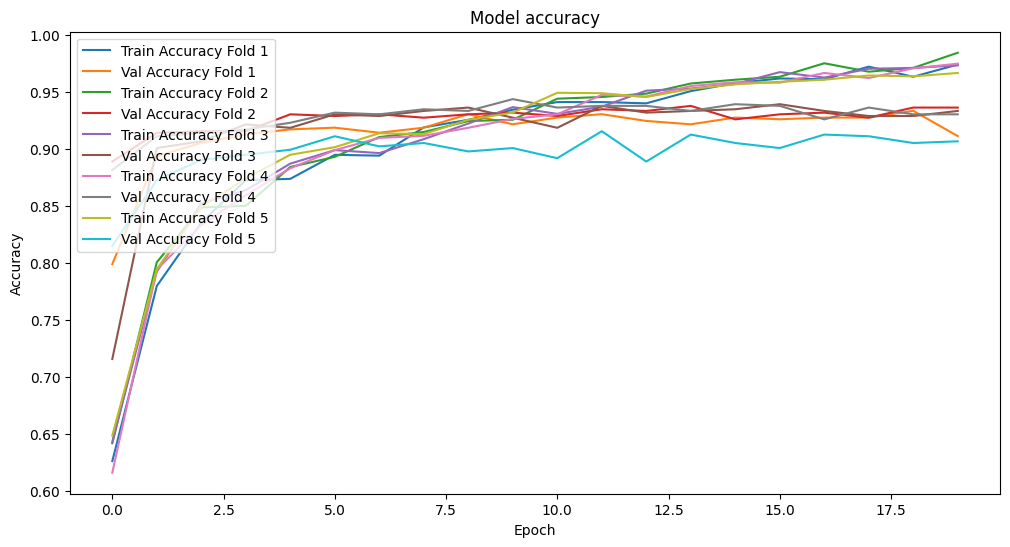

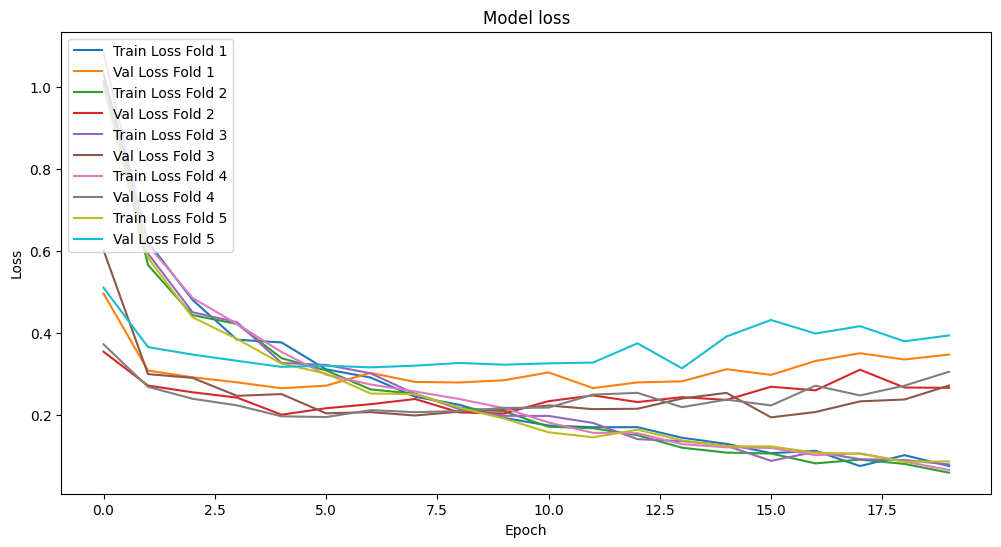

Average Validation Accuracy: 0.923581862449646
Validation Accuracies for each fold: [0.9112426042556763, 0.936296284198761, 0.9333333373069763, 0.9303703904151917, 0.9066666960716248]
Average TPR: [0.92735133 0.99551395 0.82549522 0.94023784]
Average TNR: [0.97339395 0.99801267 0.96712115 0.96019043]
Average FPR: [0.02660605 0.00198733 0.03287885 0.03980957]
Average FNR: [0.07264867 0.00448605 0.17450478 0.05976216]
Found 4217 images belonging to 4 classes.
132/132 - 1304s - 10s/step - accuracy: 0.9400 - loss: 0.2570
132/132 ━━━━━━━━━━━━━━━━━━━━ 1139s 9s/step
Test Data Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.96      0.96      1038
diabetic_retinopathy       0.99      1.00      1.00      1098
            glaucoma       0.96      0.82      0.88      1007
              normal       0.85      0.98      0.91      1074

            accuracy                           0.94      4217
           macro avg       

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
histories = []
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = create_hybrid_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    histories.append(history)
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
    class_report = classification_report(y_val, y_val_pred_classes, target_names=list(class_counts.keys()))
    TPR, TNR, FPR, FNR = calculate_metrics(conf_matrix)
    tpr_list.append(TPR)
    tnr_list.append(TNR)
    fpr_list.append(FPR)
    fnr_list.append(FNR)
    print(f"Fold {fold_no} - Classification Report:\n{class_report}")
    print(f"Fold {fold_no} - Confusion Matrix:\n{conf_matrix}")
    print(f"Fold {fold_no} - TPR: {TPR}")
    print(f"Fold {fold_no} - TNR: {TNR}")
    print(f"Fold {fold_no} - FPR: {FPR}")
    print(f"Fold {fold_no} - FNR: {FNR}")
    accuracies.append(history.history['val_accuracy'][-1])
    fold_no += 1

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

print(f"Average Validation Accuracy: {np.mean(accuracies)}")
print(f"Validation Accuracies for each fold: {accuracies}")

avg_tpr = np.mean(tpr_list, axis=0)
avg_tnr = np.mean(tnr_list, axis=0)
avg_fpr = np.mean(fpr_list, axis=0)
avg_fnr = np.mean(fnr_list, axis=0)

print(f"Average TPR: {avg_tpr}")
print(f"Average TNR: {avg_tnr}")
print(f"Average FPR: {avg_fpr}")
print(f"Average FNR: {avg_fnr}")

test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_data, test_labels = generator_to_numpy(test_generator)
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

test_pred = model.predict(test_data)
test_pred_classes = np.argmax(test_pred, axis=1)

conf_matrix_test = confusion_matrix(test_labels, test_pred_classes)
class_report_test = classification_report(test_labels, test_pred_classes, target_names=list(class_counts.keys()))

print(f"Test Data Classification Report:\n{class_report_test}")
print(f"Test Data Confusion Matrix:\n{conf_matrix_test}")